In [2]:
import pandas as pd
import numpy as np
from torch.utils.data import Dataset, DataLoader
import torch
import os
import torch.nn as nn
import random

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
SEED = 42

In [7]:
def seed_everything(seed: int):

    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.benchmark = True

seed_everything(SEED)


In [5]:
from training_nn import training_cnn
from evaluation import plot_loss, evaluate_model_cnn
from process_data import get_desc

In [7]:
train = pd.read_csv('../data/ab/train.gz', compression = 'gzip')
test = pd.read_csv('../data/ab/test.csv.gz', compression = 'gzip')

In [8]:
train.head()

junction_aa    v_call  consensus_count    j_call  \
0  KNEGFNCYIPLVTYGFHTTTGVSY  IGHV_RBD                1  IGHJ_RBD   
1  KNKGFNCYSPITEYGFFPTNGKNF  IGHV_RBD                2  IGHJ_RBD   
2  SKQGFNCYCPLIGYGFQRTFGVGW  IGHV_RBD                1  IGHJ_RBD   
3  KNRQFNCYWPLVRYGFWTTSGVGW  IGHV_RBD                1  IGHJ_RBD   
4  KNPGFNCYLPLGHYGFQPTNGRDF  IGHV_RBD                3  IGHJ_RBD   

   clonal_frequency  Label  Distance Antibody  \
0          0.000028      0         7     LY16   
1          0.000093      1         9     LY16   
2          0.000028      0         9     LY16   
3          0.000028      0         9     LY16   
4          0.000140      1         7     LY16   

                                                repr  
0  [[ 0.0000000e+00  0.0000000e+00  0.0000000e+00...  
1  [[ 0.0000000e+00  0.0000000e+00  0.0000000e+00...  
2  [[ 0.0000000e+00  0.0000000e+00  0.0000000e+00...  
3  [[ 0.0000000e+00  0.0000000e+00  0.0000000e+00...  
4  [[ 0.00000000e+00  0.00000000e+00  0.00000000e...

In [15]:
train['repr'] = get_desc(train)

In [16]:
test['repr'] = get_desc(test)

In [17]:
test.head()

junction_aa    v_call  consensus_count    j_call  \
0  KNTGFNCYFPLLAYGFHPTSGVDY  IGHV_RBD                1  IGHJ_RBD   
1  KNPGFNCYHPIVGYGFQPTIGHDF  IGHV_RBD                1  IGHJ_RBD   
2  TTAGFNCYMPITRYGFWPTDGRSW  IGHV_RBD                1  IGHJ_RBD   
3  RNRGFNCYDPIHKYGFHRTNGLNY  IGHV_RBD                1  IGHJ_RBD   
4  KNKKFNCYVPLVTYGFHPTNGVNY  IGHV_RBD                1  IGHJ_RBD   

   clonal_frequency  Label  Distance Antibody  \
0          0.000063      0         6     LY16   
1          0.000047      1         9     LY16   
2          0.000028      0        12     LY16   
3          0.000047      1        10     LY16   
4          0.000028      0         7     LY16   

                                                repr  
0  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...  
1  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...  
2  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...  
3  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...  
4  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...

In [18]:
train.head()

junction_aa    v_call  consensus_count    j_call  \
0  KNEGFNCYIPLVTYGFHTTTGVSY  IGHV_RBD                1  IGHJ_RBD   
1  KNKGFNCYSPITEYGFFPTNGKNF  IGHV_RBD                2  IGHJ_RBD   
2  SKQGFNCYCPLIGYGFQRTFGVGW  IGHV_RBD                1  IGHJ_RBD   
3  KNRQFNCYWPLVRYGFWTTSGVGW  IGHV_RBD                1  IGHJ_RBD   
4  KNPGFNCYLPLGHYGFQPTNGRDF  IGHV_RBD                3  IGHJ_RBD   

   clonal_frequency  Label  Distance Antibody  \
0          0.000028      0         7     LY16   
1          0.000093      1         9     LY16   
2          0.000028      0         9     LY16   
3          0.000028      0         9     LY16   
4          0.000140      1         7     LY16   

                                                repr  
0  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...  
1  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...  
2  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...  
3  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...  
4  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...

In [19]:
def make_map():
    mapp_ = {}
    for i, ab in enumerate(train['Antibody'].unique()):
        mapp_[ab] = i
    return mapp_

In [20]:
mapp_ = make_map()

In [21]:
def func_(x):
    pos = mapp_[x['Antibody']]
    features = x['repr']
    ab_feature = np.zeros((24, 1))
    ab_feature[pos] = 1
    features = np.concatenate((ab_feature, features), axis=1)
    return features

In [22]:
train['repr'] = train.apply(func_, axis=1)

In [23]:
test['repr'] = test.apply(func_, axis=1)

In [32]:
train.head()

junction_aa    v_call  consensus_count    j_call  \
0  KNEGFNCYIPLVTYGFHTTTGVSY  IGHV_RBD                1  IGHJ_RBD   
1  KNKGFNCYSPITEYGFFPTNGKNF  IGHV_RBD                2  IGHJ_RBD   
2  SKQGFNCYCPLIGYGFQRTFGVGW  IGHV_RBD                1  IGHJ_RBD   
3  KNRQFNCYWPLVRYGFWTTSGVGW  IGHV_RBD                1  IGHJ_RBD   
4  KNPGFNCYLPLGHYGFQPTNGRDF  IGHV_RBD                3  IGHJ_RBD   

   clonal_frequency  Label  Distance Antibody  \
0          0.000028      0         7     LY16   
1          0.000093      1         9     LY16   
2          0.000028      0         9     LY16   
3          0.000028      0         9     LY16   
4          0.000140      1         7     LY16   

                                                repr  
0  [[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...  
1  [[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...  
2  [[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...  
3  [[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...  
4  [[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...

In [35]:
def get_data(train, test, samples = 200, target_ab = 'REGN33'):
    target_df = train.loc[train['Antibody'] == target_ab]
    rest_df = train.loc[train['Antibody'] != target_ab]
    target_test = test.loc[test['Antibody'] == target_ab]
    sample_target = target_df.sample(n=samples, random_state=SEED)
    train_target = sample_target.iloc[:100, :]
    valid_target = sample_target.iloc[100:, :]
    return train_target, valid_target, target_test, rest_df

In [37]:
train_target, valid_target, target_test, rest_df = get_data(train, test)

In [38]:
class Data(Dataset):
    def __init__(self, df):
        self.df = df
    
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        feature = self.df.repr.iloc[idx]
        label = self.df.Label.iloc[idx]
        return feature, label

In [41]:
def prepare_dataloader(df, batch_size=5, shuffle=True):
    dataset = Data(df)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=shuffle, num_workers=2)
    return dataloader

In [68]:
train_loader_rest = prepare_dataloader(rest_df, shuffle=True, batch_size=10)
validloader = prepare_dataloader(valid_target, shuffle=False, batch_size=2)
train_loader_target = prepare_dataloader(train_target, shuffle=True, batch_size=2)
testloader = prepare_dataloader(target_test, shuffle=False, batch_size=10)

In [49]:
class CNNModel(nn.Module):
    def __init__(self, embed_size, hidden_size, num_classes=1):
        super().__init__()
        self.cnn = nn.Sequential(
            nn.Conv1d(embed_size, hidden_size, kernel_size=3,
                      padding=1, stride=2),
            nn.BatchNorm1d(hidden_size),
            nn.ReLU(),
            nn.Conv1d(hidden_size, hidden_size, kernel_size=3, padding=1, stride=2),
            nn.BatchNorm1d(hidden_size),
            nn.ReLU(),
            nn.Conv1d(hidden_size, hidden_size, kernel_size=3, padding=1, stride=2),
            nn.BatchNorm1d(hidden_size),
            nn.ReLU(),
            nn.AdaptiveMaxPool1d(1),
            nn.Flatten(), nn.ReLU()
        )
        self.cl = nn.Sequential(nn.Linear(hidden_size, num_classes))

    def forward(self, x):
        x = x.permute(0, 2, 1)
        x = self.cnn(x)
        prediction = self.cl(x)
        return prediction

In [51]:
model = CNNModel(41, 100).to(device)

In [52]:
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
num_epochs = 30

In [54]:
loss_train_hist, loss_valid_hist = training_cnn(model, criterion, optimizer, num_epochs, train_loader_target, validloader)

100%|██████████| 30/30 [00:35<00:00,  1.18s/it]


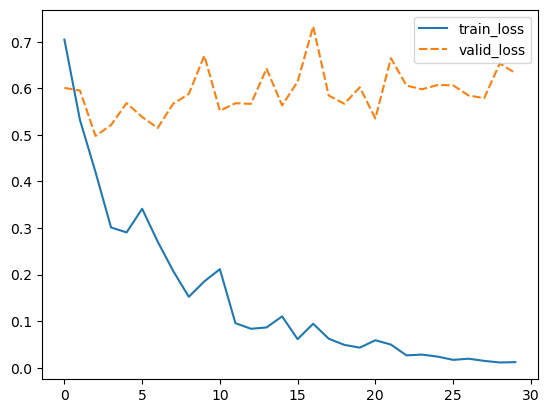

In [60]:
plot_loss(loss_train_hist, loss_valid_hist)

In [61]:
evaluate_model_cnn(testloader, model)

accuracy    recall  precision  f1_scor       auc
0  0.767463  0.726878   0.790641  0.75742  0.853307

__Training base model__

In [76]:
model = CNNModel(41, 150).to(device)
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)
num_epochs = 30
loss_train_hist, loss_valid_hist = training_cnn(model, criterion, optimizer, num_epochs, train_loader_rest, validloader)

100%|██████████| 30/30 [23:13<00:00, 46.45s/it]


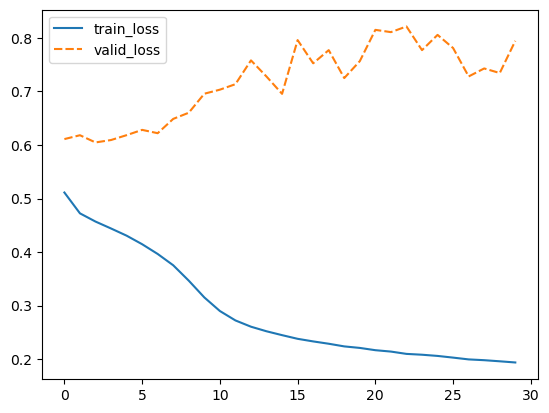

In [77]:
plot_loss(loss_train_hist, loss_valid_hist)

In [78]:
evaluate_model_cnn(testloader, model)

accuracy    recall  precision  f1_scor       auc
0  0.639665  0.398441   0.768652  0.52483  0.765456

In [120]:
def copy_model(model, *args):
    model_copy = type(model)(*args)
    model_copy.load_state_dict(model.state_dict())
    return model_copy.to(device)

In [125]:
model_copy = copy_model(model, 41, 150)

In [134]:
def freeze_weights(model, name_layers=['None']):
    for name, param in model.named_parameters():
        if not any([layer in name for layer in name_layers]):
            param.requires_grad = False
    return model

In [135]:
model_copy = freeze_weights(model_copy)   # freeze all weights

In [ ]:
def add_layers(model):
    new_layers = nn.Sequential(
    nn.Linear(150, 75),
    nn.ReLU(inplace=True),
    nn.Dropout(p=0.5),
    nn.Linear(75, 1))
    model.cl = new_layers
    return model.to(device)
    
    

In [138]:
model_copy = add_layers(model_copy)

In [144]:
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model_copy.parameters(), lr=1e-3)
num_epochs = 40
loss_train_hist, loss_valid_hist = training_cnn(model_copy, criterion, optimizer, num_epochs, train_loader_target, validloader)

100%|██████████| 40/40 [00:34<00:00,  1.16it/s]


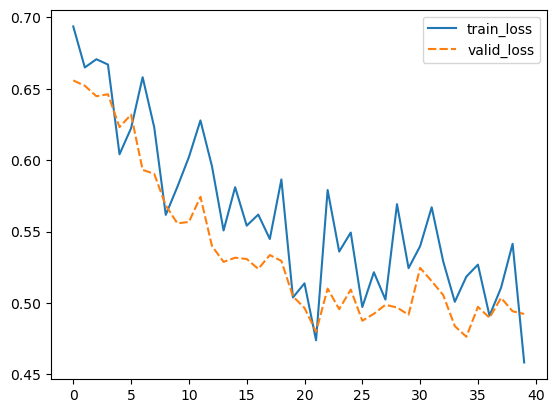

In [145]:
plot_loss(loss_train_hist, loss_valid_hist)

In [146]:
evaluate_model_cnn(testloader, model_copy)

accuracy    recall  precision   f1_scor       auc
0  0.724115  0.500824    0.90395  0.644545  0.861503